# Beer style prediction

## Set up environment

In [1]:
# Import modules
import pandas as pd
import numpy as np
from joblib import dump
from joblib import load
from pandas_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.nn import functional as F

## Get data

In [2]:
# Load magic command for auto-reloading external modules
%load_ext autoreload
%autoreload 2

In [3]:
# Turn off table squishing
pd.options.display.max_columns = None

# Import data
df = pd.read_csv("../data/raw/beer_reviews.csv")

# Check data
#display(df)

## Check data

In [4]:
# Generate Data Dictionary
# Direct copy & paste from Assignment 2 Brief

DataDict = \
    { "brewery_id": "Identifier of brewery"
    , "brewery_name": "Name of brewery"
    , "review_time": "Timestamp of review"
    , "review_overall": "Overall score given by reviewer"
    , "review_aroma": "Score given by reviewer regarding beer aroma"
    , "review_appearance": "Score given by reviewer regarding beer appearance"
    , "review_profilename": "Profile name of reviewer"
    , "review_palate": "Score given by reviewer regarding beer palate"
    , "review_taste": "Score given by reviewer regarding beer taste"
    , "beer_style (target)": "Type of beer"
    , "beer_name": "Name of beer"
    , "beer_abv": "Alcohol by volume measure"
    , "beer_beerid": "Identifier of beer"
    }

In [5]:
#df.head()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586614 entries, 0 to 1586613
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   brewery_id          1586614 non-null  int64  
 1   brewery_name        1586599 non-null  object 
 2   review_time         1586614 non-null  int64  
 3   review_overall      1586614 non-null  float64
 4   review_aroma        1586614 non-null  float64
 5   review_appearance   1586614 non-null  float64
 6   review_profilename  1586266 non-null  object 
 7   beer_style          1586614 non-null  object 
 8   review_palate       1586614 non-null  float64
 9   review_taste        1586614 non-null  float64
 10  beer_name           1586614 non-null  object 
 11  beer_abv            1518829 non-null  float64
 12  beer_beerid         1586614 non-null  int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 157.4+ MB


In [7]:
# df.describe()

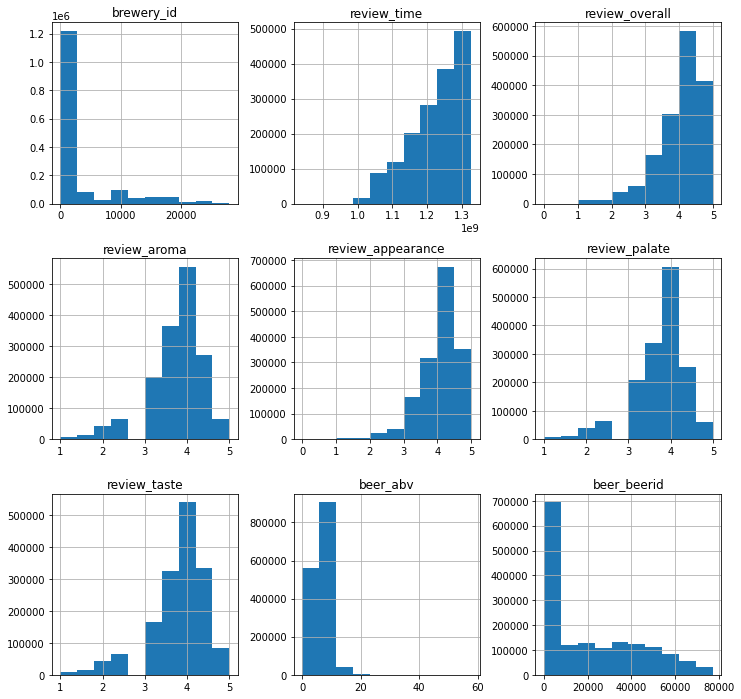

In [8]:
# Show distribution of numerical variables
import matplotlib.pyplot as plt

df.hist(figsize=(12,12))
plt.show()

In [9]:
# Identify any null values per variable
print(df.isnull().sum())

brewery_id                0
brewery_name             15
review_time               0
review_overall            0
review_aroma              0
review_appearance         0
review_profilename      348
beer_style                0
review_palate             0
review_taste              0
beer_name                 0
beer_abv              67785
beer_beerid               0
dtype: int64


In [10]:
# Identify any duplicate observations (ie same reviewer rating beer multiple times)
df_dupe = df.sort_values('review_overall', ascending=False)
df_dupe = df_dupe.drop_duplicates(['review_profilename', 'beer_name'], keep='first')
print('Duplicates:',len(df)-len(df_dupe))

Duplicates: 24882


In [11]:
# Reviewers
#df.value_counts(['review_profilename']).reset_index(name='reviewers')

In [12]:
# Summary table by beer_style

# Beers per beer_style
df_beers = df[['beer_name', 'brewery_name', 'beer_style', 'beer_abv']].drop_duplicates()
beers = df_beers.value_counts(['beer_style']).reset_index(name='beer_count')

# Reviews per beer_style
reviews = df.groupby('beer_style')['review_overall'].count().reset_index(name='review_count')

# Reviewers per beer_style
reviewers = df.groupby('beer_style')['review_profilename'].nunique().reset_index(name='reviewer_count')

# Average review_overall per beer_style
avg = df.groupby('beer_style')['review_overall'].mean().reset_index(name='avg review_overall')

# Merged dataframe
beer_style_summary = beers.merge(right=reviews, how='left', on='beer_style')
beer_style_summary = beer_style_summary.merge(right=reviewers, how='left', on='beer_style')
beer_style_summary = beer_style_summary.merge(right=avg, how='left', on='beer_style')
beer_style_summary

,beer_style,beer_count,review_count,reviewer_count,avg review_overall
0,American IPA,3599,117586,12480,3.965221
1,American Pale Ale (APA),3330,63469,9252,3.852306
2,American Amber / Red Ale,2500,45751,8337,3.781010
3,American Porter,2188,50477,8464,3.895735
4,Fruit / Vegetable Beer,1833,33861,7336,3.415124
...,...,...,...,...,...
99,Kvass,44,297,157,3.355219
100,Gose,33,686,551,3.965015
101,Sahti,28,1061,832,3.700283
102,Bière de Champagne / Bière Brut,20,1046,815,3.648184


## Prepare data

In [63]:
# Create a copy of df and save it into a variable called df_cleaned
df_cleaned = df.copy()

In [64]:
# Drop duplicates
df_cleaned = df_cleaned.sort_values('review_overall', ascending=False)
df_cleaned = df_cleaned.drop_duplicates(['review_profilename', 'beer_name'], keep='first')

In [65]:
# Drop NAs from relevant variables
df_cleaned = df_cleaned.dropna(subset=['brewery_name', 'review_profilename'])

In [66]:
# Drop variables not required
df_cleaned = df_cleaned.drop(['brewery_id', 'review_time', 'review_overall', 'review_profilename', 'beer_name', 'beer_abv', 'beer_beerid'], axis=1)

In [67]:
# Label encoder for target variable
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html#sklearn.preprocessing.LabelEncoder

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df_cleaned['beer_style'])
df_cleaned['beer_style'] = le.transform(df_cleaned['beer_style'])

In [68]:
# Import StandardScaler and OrdinalEncoder from sklearn.preprocessing
from sklearn.preprocessing import OrdinalEncoder

In [69]:
# Create lists of unique values for categorical variables
brewery_set = set(df_cleaned['brewery_name'])
brewery_list = list(brewery_set)

In [70]:
# Create dictionary of categorical variables
cats_dict = {
    #'beer_style': [beer_list],
    'brewery_name': [brewery_list],
}

In [71]:
for col, cats in cats_dict.items():
    col_encoder = OrdinalEncoder(categories=cats)
    df_cleaned[col] = col_encoder.fit_transform(df_cleaned[[col]])

In [72]:
df_cleaned['brewery_name'] = df_cleaned['brewery_name'].astype(int)

In [73]:
# Create a list called num_cols that contains all numeric columns
### is scaler necessary? are there different ranges for these variables, or all 0-5?
num_cols = ['brewery_name', 'review_aroma', 'review_appearance', 'review_palate', 'review_taste']

In [74]:
# Instantiate a StandardScaler and called it sc
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

# Fit and transform the numeric features and replace the data into it
df_cleaned[num_cols] = sc.fit_transform(df_cleaned[num_cols])

In [75]:
df_cleaned

,brewery_name,review_aroma,review_appearance,beer_style,review_palate,review_taste
793307,-1.550137,-1.771980,-1.366164,14,0.374534,-0.401427
591801,-0.049933,1.811546,1.068157,11,1.840525,0.964681
591818,-0.049933,1.811546,1.879597,11,1.107529,1.647735
591819,-0.049933,1.094841,0.256716,11,1.107529,1.647735
591824,-0.049933,1.094841,-0.554724,11,1.840525,1.647735
...,...,...,...,...,...,...
653706,-0.146492,-1.055274,-6.234806,2,-1.824453,-0.401427
37234,-0.897183,-2.488685,-6.234806,36,-1.091457,-2.450590
653695,-0.146492,-2.488685,-6.234806,65,-1.824453,-2.450590
39667,-0.897183,-1.055274,-6.234806,14,-2.557448,-2.450590


In [76]:
#from src.data.sets import split_sets_random, save_sets, pop_target

def split_sets_random(df, target_col, test_ratio=0.2, to_numpy=False):
    """Split sets randomly

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe
    target_col : str
        Name of the target column
    test_ratio : float
        Ratio used for the validation and testing sets (default: 0.2)

    Returns
    -------
    Numpy Array
        Features for the training set
    Numpy Array
        Target for the training set
    Numpy Array
        Features for the validation set
    Numpy Array
        Target for the validation set
    Numpy Array
        Features for the testing set
    Numpy Array
        Target for the testing set
    """
    
    from sklearn.model_selection import train_test_split
    
    features, target = pop_target(df=df, target_col=target_col, to_numpy=to_numpy)
    
    X_data, X_test, y_data, y_test = train_test_split(features, target, test_size=test_ratio, random_state=8)
    
    val_ratio = test_ratio / (1 - test_ratio)
    X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=val_ratio, random_state=8)

    return X_train, y_train, X_val, y_val, X_test, y_test


def save_sets(X_train=None, y_train=None, X_val=None, y_val=None, X_test=None, y_test=None, path='../data/processed/'):
    import numpy as np

    if X_train is not None:
      np.save(f'{path}X_train', X_train)
    if X_val is not None:
      np.save(f'{path}X_val',   X_val)
    if X_test is not None:
      np.save(f'{path}X_test',  X_test)
    if y_train is not None:
      np.save(f'{path}y_train', y_train)
    if y_val is not None:
      np.save(f'{path}y_val',   y_val)
    if y_test is not None:
      np.save(f'{path}y_test',  y_test)
    
def pop_target(df, target_col, to_numpy=False):
    """Extract target variable from dataframe and convert to nympy arrays if required

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe
    target_col : str
        Name of the target variable
    to_numpy : bool
        Flag stating to convert to numpy array or not

    Returns
    -------
    pd.DataFrame/Numpy array
        Subsetted Pandas dataframe containing all features
    pd.DataFrame/Numpy array
        Subsetted Pandas dataframe containing the target
    """

    df_copy = df.copy()
    target = df_copy.pop(target_col)
    
    if to_numpy:
        df_copy = df_copy.to_numpy()
        target = target.to_numpy()
    
    return df_copy, target

In [77]:
# Split data into training and testing with 80-20 ratio
X_train, y_train, X_val, y_val, X_test, y_test = split_sets_random(df_cleaned, target_col='beer_style', test_ratio=0.2, to_numpy=True)

# Save sets to folder
save_sets(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, X_test=X_test, y_test=y_test, path='../data/processed/')

In [78]:
# Import this class from src/models/pytorch and convert all sets to PytorchDataset
#from src.models.pytorch import PytorchDataset

from torch.utils.data import Dataset, DataLoader

class PytorchDataset(Dataset):
    """
    Pytorch dataset
    ...

    Attributes
    ----------
    X_tensor : Pytorch tensor
        Features tensor
    y_tensor : Pytorch tensor
        Target tensor

    Methods
    -------
    __getitem__(index)
        Return features and target for a given index
    __len__
        Return the number of observations
    to_tensor(data)
        Convert Pandas Series to Pytorch tensor
    """
        
    def __init__(self, X, y):
        self.X_tensor = self.to_tensor(X)
        self.y_tensor = self.to_tensor(y)
    
    def __getitem__(self, index):
        return self.X_tensor[index], self.y_tensor[index]
        
    def __len__ (self):
        return len(self.X_tensor)
    
    def to_tensor(self, data):
        return torch.Tensor(np.array(data))

In [79]:
train_dataset = PytorchDataset(X=X_train, y=y_train)
val_dataset = PytorchDataset(X=X_val, y=y_val)
test_dataset = PytorchDataset(X=X_test, y=y_test)

## Baseline

In [80]:
# Import NullModel from src.models.null
#from src.models.null import NullModel
import pandas as pd
import numpy as np

class NullModel:
    """
    Class used as baseline model for both regression and classification
    ...

    Attributes
    ----------
    target_type : str
        Type of ML problem (default regression)
    y : Numpy Array-like
        Target variable
    pred_value : Float
        Value to be used for prediction
    preds : Numpy Array
        Predicted array

    Methods
    -------
    fit(y)
        Store the input target variable and calculate the predicted value to be used based on the problem type
    get_length
        Calculate the number of observations from the target variable
    predict(y)
        Generate the predictions
    fit_predict(y)
        Perform a fit followed by predict
    """
        
    
    def __init__(self, target_type: str = "regression"):
        self.target_type = target_type
        self.y = None
        self.pred_value = None
        self.preds = None
        
    def fit(self, y):
        self.y = y
        if self.target_type == "regression":
            self.pred_value = y.mean()
        else:
            from scipy.stats import mode
            self.pred_value = mode(y)[0][0]
            
    def get_length(self):
        return len(self.y)
    
    def predict(self, y):
        self.preds = np.full((self.get_length(), 1), self.pred_value)
        return self.preds
    
    def fit_predict(self, y):
        self.fit(y)
        return self.predict(self.y)

In [81]:
# Instantiate a NullModel and call .fit_predict() on the training target to extract your predictions into a variable called y_base
baseline_model = NullModel(target_type='classification')
y_base = baseline_model.fit_predict(y_train)

In [82]:
# Import print_class_perf from src.models.performance
#from src.models.performance import print_class_perf

def print_class_perf(y_preds, y_actuals, set_name=None, average='binary'):
    """Print the Accuracy and F1 score for the provided data

    Parameters
    ----------
    y_preds : Numpy Array
        Predicted target
    y_actuals : Numpy Array
        Actual target
    set_name : str
        Name of the set to be printed
    average : str
        Parameter  for F1-score averaging
    Returns
    -------
    """
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score

    print(f"Accuracy {set_name}: {accuracy_score(y_actuals, y_preds)}")
    print(f"F1 {set_name}: {f1_score(y_actuals, y_preds, average=average)}")

In [83]:
# # Task: Print the classification metrics for this baseline model
print_class_perf(y_base, y_train, set_name='Training', average='weighted')

Accuracy Training: 0.07332889284547743
F1 Training: 0.01001953187282294


## Define architecture

In [84]:
# Import torch and torch.nn as nn
import torch
import torch.nn as nn
import torch.nn.functional as F

In [85]:
# Instantiate PytorchMultiClass with the correct number of input feature and save it into a variable called model
#from src.models.pytorch import PytorchMultiClass

class PytorchMultiClass(nn.Module):
    def __init__(self, num_features):
        super(PytorchMultiClass, self).__init__()
        
        self.layer_1 = nn.Linear(num_features, 32)
        self.layer_2 = nn.Linear(32,16)
        self.layer_3 = nn.Linear(16,8)
        self.layer_out = nn.Linear(8, 104) #Number of classes in target variable
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = F.dropout(F.relu(self.layer_1(x)), training=self.training)
        x = F.dropout(F.relu(self.layer_2(x)), training=self.training)
        x = F.dropout(F.relu(self.layer_3(x)), training=self.training)
        x = self.layer_out(x)
        return self.softmax(x)

In [86]:
model = PytorchMultiClass(X_train.shape[1])

In [87]:
# Set model to use the device available
#from src.models.pytorch import get_device

def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

device = get_device()
model.to(device)

PytorchMultiClass(
  (layer_1): Linear(in_features=5, out_features=32, bias=True)
  (layer_2): Linear(in_features=32, out_features=16, bias=True)
  (layer_3): Linear(in_features=16, out_features=8, bias=True)
  (layer_out): Linear(in_features=8, out_features=104, bias=True)
  (softmax): Softmax(dim=1)
)

In [88]:
# Print the architecture of model
print(model)

PytorchMultiClass(
  (layer_1): Linear(in_features=5, out_features=32, bias=True)
  (layer_2): Linear(in_features=32, out_features=16, bias=True)
  (layer_3): Linear(in_features=16, out_features=8, bias=True)
  (layer_out): Linear(in_features=8, out_features=104, bias=True)
  (softmax): Softmax(dim=1)
)


## Train model

In [89]:
# Instantiate a nn.CrossEntropyLoss() and save it into a variable called criterion
criterion = nn.CrossEntropyLoss()

In [90]:
# Instantiate a torch.optim.Adam() optimizer with the model's parameters and learning rate and save it into a variable called optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [91]:
# Create a function called train_classification() that will perform forward and back propagation and calculate loss and Accuracy scores
from torch.utils.data import DataLoader

def train_classification(train_data, model, criterion, optimizer, batch_size, device, scheduler=None, generate_batch=None):
    """Train a Pytorch multi-class classification model

    Parameters
    ----------
    train_data : torch.utils.data.Dataset
        Pytorch dataset
    model: torch.nn.Module
        Pytorch Model
    criterion: function
        Loss function
    optimizer: torch.optim
        Optimizer
    bacth_size : int
        Number of observations per batch
    device : str
        Name of the device used for the model
    scheduler : torch.optim.lr_scheduler
        Pytorch Scheduler used for updating learning rate
    collate_fn : function
        Function defining required pre-processing steps

    Returns
    -------
    Float
        Loss score
    Float:
        Accuracy Score
    """
    
    # Set model to training mode
    model.train()
    train_loss = 0
    train_acc = 0
    
    # Create data loader
    data = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)
    
    # Iterate through data by batch of observations
    for feature, target_class in data:

        # Reset gradients
        optimizer.zero_grad()
        
        # Load data to specified device
        feature, target_class = feature.to(device), target_class.to(device)
        
        # Make predictions
        output = model(feature)
        
        # Calculate loss for given batch
        loss = criterion(output, target_class.long())

        # Calculate global loss
        train_loss += loss.item()
        
        # Calculate gradients
        loss.backward()

        # Update Weights
        optimizer.step()
        
        # Calculate global accuracy
        train_acc += (output.argmax(1) == target_class).sum().item()

    # Adjust the learning rate
    if scheduler:
        scheduler.step()

    return train_loss / len(train_data), train_acc / len(train_data)

In [92]:
# Create a function called test_classification() that will perform forward and calculate loss and accuracy scores
def test_classification(test_data, model, criterion, batch_size, device, generate_batch=None):
    """Calculate performance of a Pytorch multi-class classification model

    Parameters
    ----------
    test_data : torch.utils.data.Dataset
        Pytorch dataset
    model: torch.nn.Module
        Pytorch Model
    criterion: function
        Loss function
    bacth_size : int
        Number of observations per batch
    device : str
        Name of the device used for the model
    collate_fn : function
        Function defining required pre-processing steps

    Returns
    -------
    Float
        Loss score
    Float:
        Accuracy Score
    """    
    
    # Set model to evaluation mode
    model.eval()
    test_loss = 0
    test_acc = 0
    
    # Create data loader
    data = DataLoader(test_data, batch_size=batch_size, collate_fn=generate_batch)
    
    # Iterate through data by batch of observations
    for feature, target_class in data:
        
        # Load data to specified device
        feature, target_class = feature.to(device), target_class.to(device)
        
        # Set no update to gradients
        with torch.no_grad():
            
            # Make predictions
            output = model(feature)
            
            # Calculate loss for given batch
            loss = criterion(output, target_class.long())

            # Calculate global loss
            test_loss += loss.item()
            
            # Calculate global accuracy
            test_acc += (output.argmax(1) == target_class).sum().item()

    return test_loss / len(test_data), test_acc / len(test_data)

In [93]:
# Create 2 variables called N_EPOCHS and BATCH_SIZE that will take respectively 50 and 32 as values
N_EPOCHS = 5
BATCH_SIZE = 32

In [ ]:
# Create a for loop that will iterate through the specified number of epochs and will train the model with the training set and assess the performance on the validation set and print their scores
for epoch in range(N_EPOCHS):
    train_loss, train_acc = train_classification(train_dataset, model=model, criterion=criterion, optimizer=optimizer, batch_size=BATCH_SIZE, device=device)
    valid_loss, valid_acc = test_classification(val_dataset, model=model, criterion=criterion, batch_size=BATCH_SIZE, device=device)

    print(f'Epoch: {epoch}')
    print(f'\t(train)\t|\tLoss: {train_loss:.4f}\t|\tAcc: {train_acc * 100:.1f}%')
    print(f'\t(valid)\t|\tLoss: {valid_loss:.4f}\t|\tAcc: {valid_acc * 100:.1f}%')

Epoch: 0
	(train)	|	Loss: 0.1434	|	Acc: 7.3%
	(valid)	|	Loss: 0.1434	|	Acc: 7.4%
Epoch: 1
	(train)	|	Loss: 0.1434	|	Acc: 7.3%
	(valid)	|	Loss: 0.1434	|	Acc: 7.4%


In [ ]:
# Save the model into the models folder
torch.save(model, "../models/beer_pred.pt")
torch.save(model.state_dict(), "../models/beer_pred_state_dict.pt")

## Assess performance

In [ ]:
# Assess the model performance on the testing set and print its scores
test_loss, test_acc = test_classification(test_dataset, model=model, criterion=criterion, batch_size=BATCH_SIZE, device=device)
print(f'\tLoss: {test_loss:.4f}\t|\tAcc: {test_acc:.1f}')

In [ ]:
# Confidence matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model, X_test, y_test,
                      cmap=plt.cm.Blues,
                      colorbar=False,
                      normalize='false')

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_data.targets, train_preds.argmax(dim=1))
cm



In [ ]:
def format_feature(brewery_name: int, review_aroma: int, review_appearance: int, review_palate: int, review_taste: int ):
    return {
        'Brewery Name' : [brewery_name],
        'Review Aroma' : [review_aroma],
        'Review Appearance': [review_appearance],
        'Review Palate': [review_palate],
        'Review Taste': [review_taste]
    }

In [ ]:
# make a class prediction for one row of data
# adapted from https://machinelearningmastery.com/pytorch-tutorial-develop-deep-learning-models/
from torch import Tensor
from numpy import argmax

def predict(brewery_name: int, review_aroma: int, review_appearance:int, review_palate: int, review_taste: int):
    features = [brewery_name, review_aroma, review_appearance, review_palate, review_taste]
    # convert row to data
    features = Tensor([features])
    # make prediction
    yhat = model(features)
    # retrieve numpy array
    yhat = yhat.detach().numpy()
    return argmax(yhat)
    #return JSONResponse(pred.tolist())

In [ ]:
predict(brewery_name = 1687, review_aroma = 2.0, review_appearance = 2.5, review_palate = 2.5, review_taste = 2.5)